In [7]:
%pip install doubletdetection
%pip install scanpy


In [60]:
import numpy as np 
import pandas as pd
import scanpy as sc
import doubletdetection
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter("ignore")
sc.settings.n_jobs=8
sc.set_figure_params()
%matplotlib inline

In [73]:
adata= sc.read_10x_h5("sample_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 8058 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 7962 × 23080
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [16]:
adata.var["mt"]= adata.var_names.str.startswith("MT-") #Mitochondrial genes
adata.var["ribo"]= adata.var_names.str.startswith("RPS", "RPL") #ribosomal genes
adata.var["hb"]= adata.var_names.str.startswith("^HB[^(P)]") #hemoglobin

In [17]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

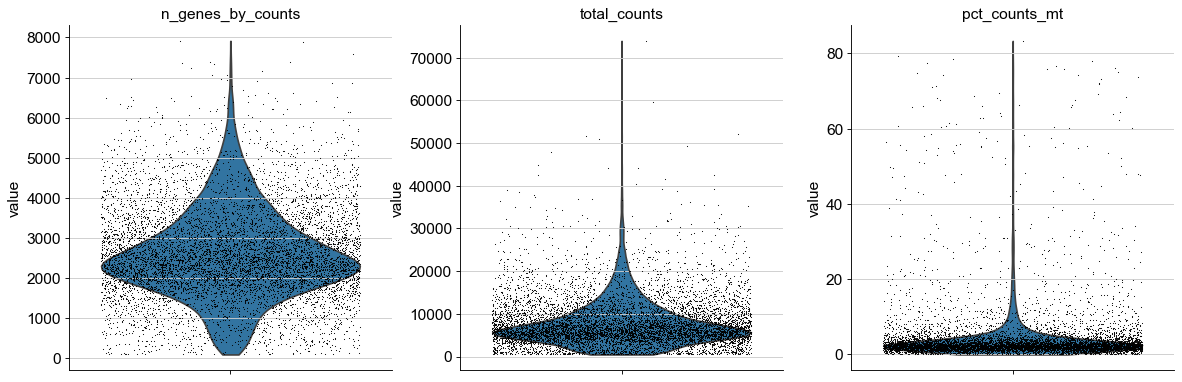

In [20]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter= 0.4, multi_panel= True)

In [34]:
# Set Boostclassifier! 
clf= doubletdetection.BoostClassifier(n_iters=10, clustering_algorithm= "louvain", standard_scaling= True, pseudocount=0.1, n_jobs=-1)

# Run doublet detection
doublets= clf.fit(adata.X).predict(p_thresh= 1e-16, voter_thresh= 0.5)
doublet_score= clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

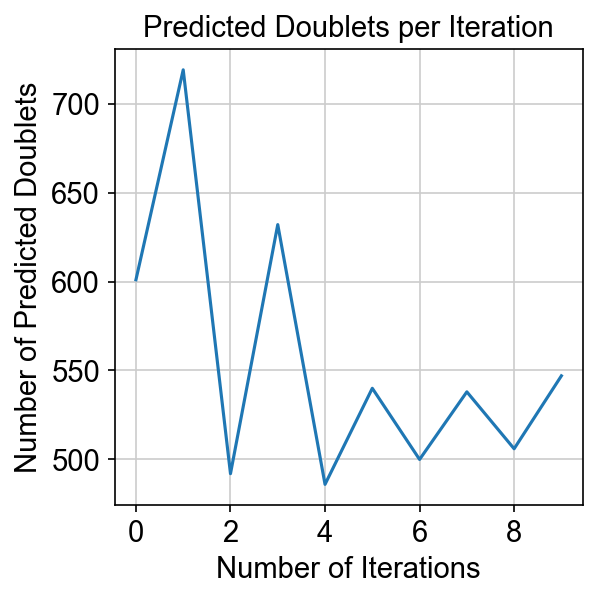

In [35]:
# Convergence of doublet calls 
f= doubletdetection.plot.convergence(clf, show= True, p_thresh=1e-16, voter_thresh=0.5)

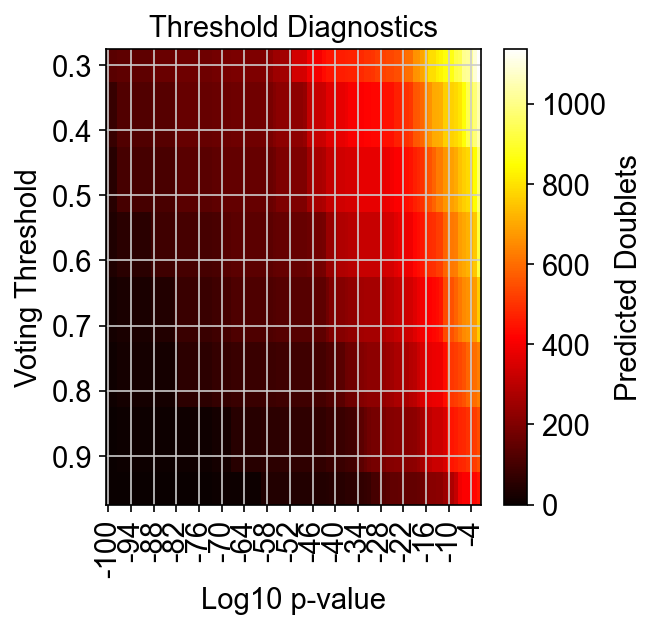

In [36]:
f3= doubletdetection.plot.threshold(clf, show=True, p_step=6)

In [41]:
adata.obs["doublet"]= doublets
adata.obs["doublet_score"]= doublet_score

In [42]:
adata

AnnData object with n_obs × n_vars = 7962 × 23080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', 'leiden', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

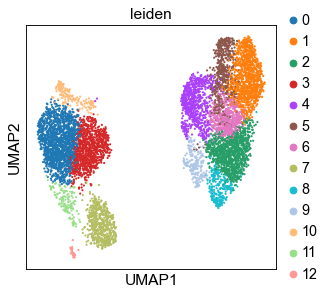

In [43]:
#Doublet on UMAP 
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color= ["leiden"])

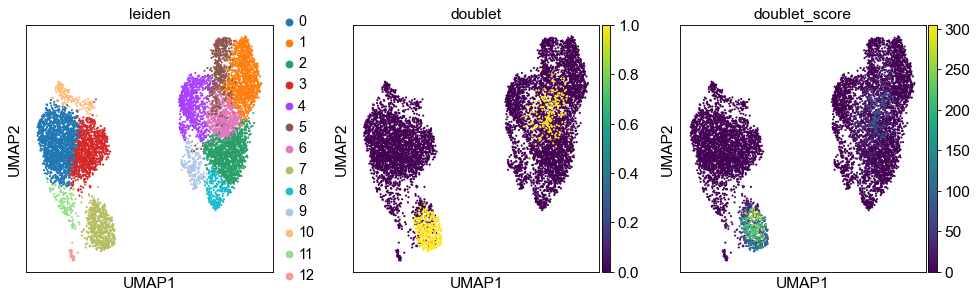

In [44]:
sc.pl.umap(adata, color= ["leiden", "doublet", "doublet_score"])

In [45]:
adata.obs["doublet"]

AAACCTGAGACTACAA-1    0.0
AAACCTGAGACTCGGA-1    0.0
AAACCTGAGCAATATG-1    0.0
AAACCTGAGCCTTGAT-1    0.0
AAACCTGCAAGCGTAG-1    0.0
                     ... 
TTTGTCAGTGCCTGTG-1    0.0
TTTGTCAGTGCGATAG-1    0.0
TTTGTCAGTTGATTCG-1    0.0
TTTGTCAGTTGATTGC-1    0.0
TTTGTCATCTTGCATT-1    0.0
Name: doublet, Length: 7962, dtype: float64

In [47]:
#subsetting using metatdta
bdata= adata[adata.obs.doublet>0]
bdata

View of AnnData object with n_obs × n_vars = 547 × 23080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', 'leiden', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

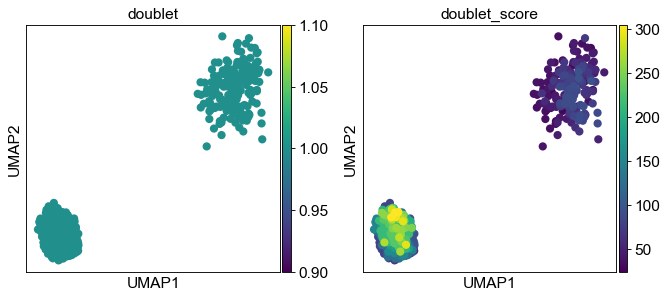

In [49]:
sc.pl.umap(bdata, color= ["doublet", "doublet_score"])

In [66]:
#subset using metadata
cdata=adata[adata.obs.doublet==0.0]
cdata

View of AnnData object with n_obs × n_vars = 7415 × 23080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', 'leiden', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [68]:
cdata.obs["singlelet"]= cdata.obs["doublet"]
cdata

AnnData object with n_obs × n_vars = 7415 × 23080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet', 'leiden', 'doublet_score', 'singlelet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [63]:
print(type(cdata))

<class 'pandas.core.series.Series'>


In [1]:
sc.pl.umap(cdata, color= ["singlelet", "doublet_score"])

NameError: name 'sc' is not defined